In [5]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx
from tqdm import tqdm
%matplotlib notebook

In [6]:
def Create_Triangular_Graph(n):
    p=[]
    for j in range(1,n+1):
        for i in range(1,n+1):
            p.append((j%2 + 2*i - 3, 2*j-2))
    
    points = p
    N = len(points)
    points = sorted(points,key=lambda l:l[1])
    
    ############################################################################
    G = nx.Graph()
    
    
    G.add_nodes_from(points)
    
    """
    for x,y in points:
    
        G.add_node((x,y),pos=(x,y))
    """
    
    dic={}  
    for n,(x,y) in zip(G.nodes(),points):
        dic[n] = (x,y)
    #############################################################################
    for a,b in G.nodes():
        if (a+1,b+2) in G.nodes():
            G.add_edge((a,b),(a+1,b+2))
        if (a-1,b+2) in G.nodes():
            G.add_edge((a,b),(a-1,b+2))
        if (a+2,b) in G.nodes():
            G.add_edge((a,b),(a+2,b))
    #####################################################################################
    return G,dic

In [7]:
def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

In [8]:
def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("black")
        else:
            node_colors.append("silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

In [9]:
def Create_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

In [10]:
from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 
    
    """
    opt_model.solve(plp.GUROBI_CMD(options=[("MIPgap", 0.01),
                                            (GRB.Param.Threads, multiprocessing.cpu_count()),
                                           ('TimeLimit', 10*3600),
                                           (GRB.param.OutputFlag, 1)]))
    """
    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue
               
                    
    return float(opt_model.objective.value()), varsdict

In [15]:
def create_data(n,choice):
    
    #G,points = Create_Triangular_Graph(n)
    #G = Add_Weights(G,1.0)
    
    k = 0.5
    
    if choice == 1:
        G = nx.triangular_lattice_graph(n,n)
    if choice == 2:
        G = nx.grid_2d_graph(n,n)
    if choice == 3:
        G = nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Create_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    return G,vr,fi

In [180]:
def Properties(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count2(G))
    print("L-f: ",len(G.edges())-frustration_count2(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))

    print(frustration_count2(G)/len(G.edges()))

In [16]:
from tqdm.notebook import tqdm

def new_Quench(G0,var,fi):
    

    p=0.0
    total=[]
    start = time.time()
    ####################################################################################
    for i in tqdm(range(500)):
        
        H = G0.copy()
        res=[]
        for k in range(0,500):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            H = color_nodes(H,var)
            
            fr = frustration_count(H)
            res.append(fr)
            

        total.append(res)
    ####################################################################################        
    end = time.time()
    print("completed",end - start)
    
    total = np.array(total)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))
        
        
    return final,total

In [17]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color'] and val['weight']==-1:
            s+=1
    return s

In [148]:
def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [18]:
G0,var,fi = create_data(10,1)

<IPython.core.display.Javascript object>


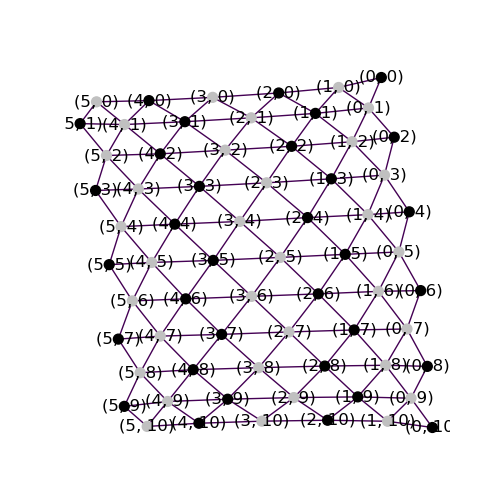

f = 50
L = 165


In [20]:
G = G0

pos = nx.spring_layout(G, weight=None)
node_colors=nx.get_node_attributes(G,'color')
edge_colors=nx.get_edge_attributes(G,'weight')

#print(edge_colors)

fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)
#Properties(G)

print("f =",frustration_count(G))
print("L =",len(G.edges()))

In [149]:
Properties(G)

N:  66
L:  165
f:  50
L-f:  115
f+:  50
f-:  0
Delta:  50
Abs(Delta):  50
0.30303030303030304


In [21]:
results, total = new_Quench(G0,var,fi)


completed 194.3901343345642


<IPython.core.display.Javascript object>


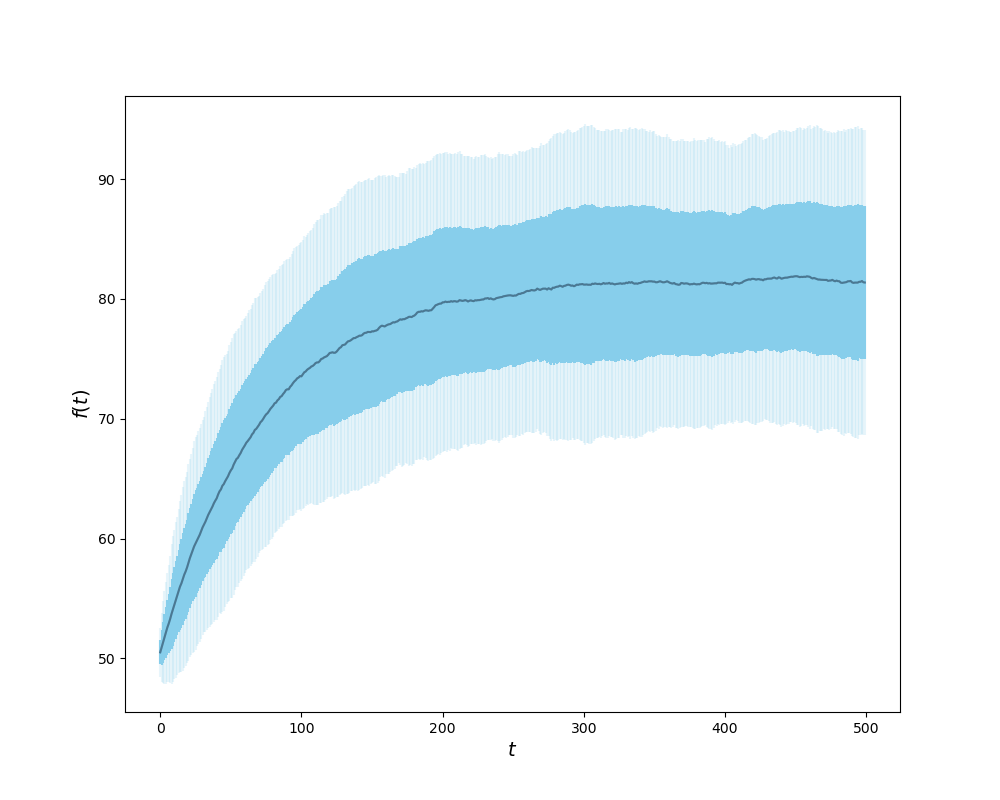

In [150]:
fig, ax = plt.subplots(figsize=[10,8])
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

#ax.set_xlabel('$x$', fontsize=14)
#ax.set_ylabel('$f(x)$', fontsize=14)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

In [61]:
def funkcija(t,L,d):
    
    a = d^2 + (-1 + L)*L
    
    b = - np.exp((t - 2*L*t)/((-1 + L)*L))*(50 + d^2 + (-101 + L)*L)
    
    c = (a+b)/(-1 + 2*L)
    
    return c
    
    #y = (d^2 + (-1 + L)*L - np.exp((t - 2*L*t)/((-1 + L)*L))*(50 + d^2 + (-101 + L)*L))/(-1 + 2*L)
    
    #print(y)

    #return y

In [62]:
funkcija(0,165,0)

50.01215805471124

<IPython.core.display.Javascript object>


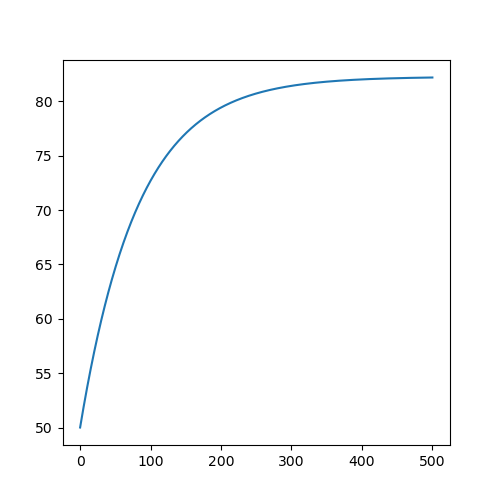

In [162]:
xs = np.linspace(0,500,1000)

fig, ax = plt.subplots(figsize=[5,5])
ax.plot(xs, funkcija(xs,165,0))
plt.show()

<IPython.core.display.Javascript object>


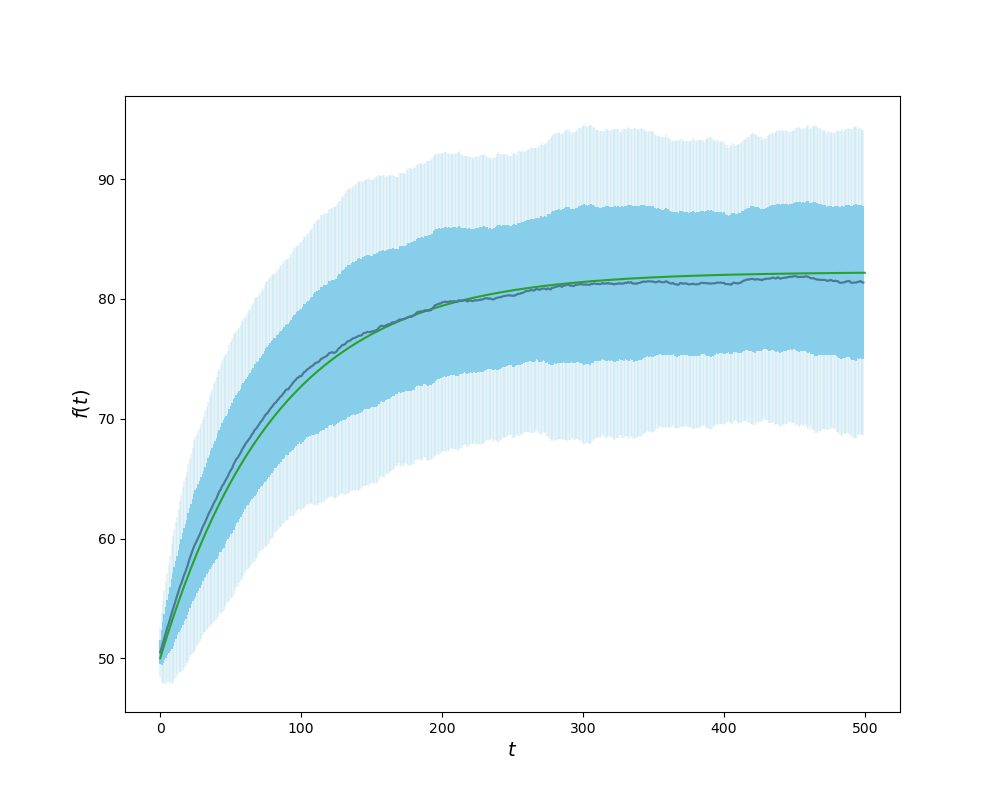

In [153]:
fig, ax = plt.subplots(figsize=[10,8])
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)
ax.plot(xs, funkcija(xs,165,0))
#ax.set_xlabel('$x$', fontsize=14)
#ax.set_ylabel('$f(x)$', fontsize=14)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

#  Sympy Solver

In [140]:
t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): 50}); gsol

Eq(x(t), (L**2 - L + d**2 + exp((-3*L*log(-L**2 + 101*L - d**2 - 50)/(2*L - 1) + t/L)/(L - 1))*exp(-(-2*L**2*log(-L**2 + 101*L - d**2 - 50)/(2*L - 1) + 2*t - log(-L**2 + 101*L - d**2 - 50)/(2*L - 1))/(L - 1)))/(2*L - 1))

<IPython.core.display.Javascript object>


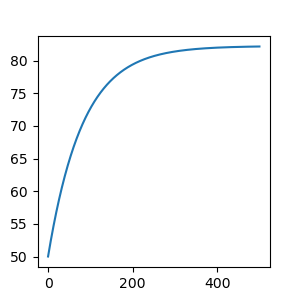

In [141]:
sol = gsol.subs({L: 165,d:0})
lmbd_sol = lambdify(t, sol.rhs)

xs = np.linspace(0,500,1000)

fig, ax = plt.subplots(figsize=[3,3])

plt.plot(xs,lmbd_sol(xs))

plt.show()

<IPython.core.display.Javascript object>


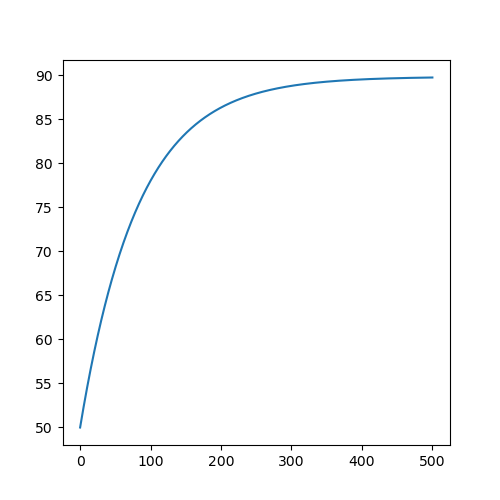

In [151]:
f0 = 50

t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

sol = gsol.subs({L: 165,d:50})
lmbd_sol = lambdify(t, sol.rhs)

xs = np.linspace(0,500,1000)

fig, ax = plt.subplots(figsize=[5,5])

plt.plot(xs,lmbd_sol(xs))

plt.show()

<IPython.core.display.Javascript object>


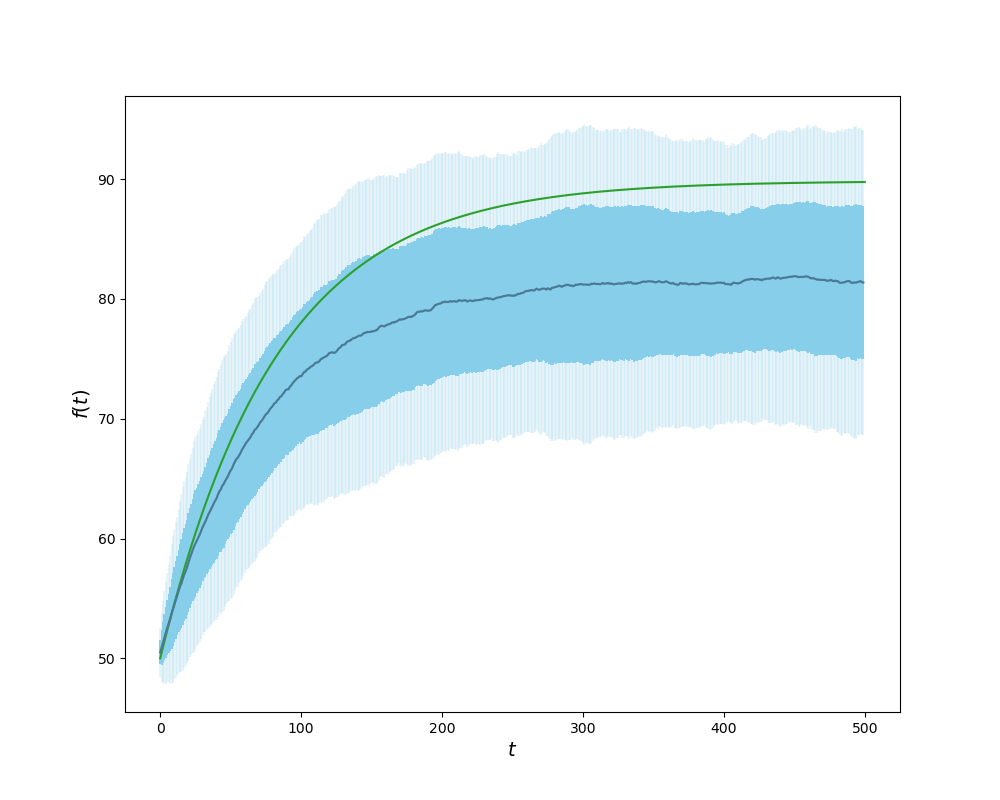

In [152]:
fig, ax = plt.subplots(figsize=[10,8])
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)
ax.plot(xs, lmbd_sol(xs))
#ax.set_xlabel('$x$', fontsize=14)
#ax.set_ylabel('$f(x)$', fontsize=14)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

# Quench with respect to delta

In [154]:
import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

In [155]:
def FG(N,k):

    #G = nx.triangular_lattice_graph(N,N)
    G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    #pos = nx.spring_layout(G, weight=None)
    #nx.set_node_attributes(G,pos,'pos')
    
    return G

In [164]:
def frustration_count2(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

In [189]:
H = simulated_annealing(FG(10,0.5),0)

In [194]:
frustration_count2(H)

88

In [190]:
Properties(H)

N:  100
L:  180
f:  88
L-f:  92
f+:  44
f-:  44
Delta:  0
Abs(Delta):  0
0.4888888888888889


In [191]:
from tqdm.notebook import tqdm

def Quench2(G0):
    

    p=0.0
    total=[]
    start = time.time()
    ####################################################################################
    for i in tqdm(range(100)):
        
        H = G0.copy()
        res=[]
        for k in range(0,100):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            #H = Add_Weights(H,1.0)
            #H = color_nodes(H,var)
            
            fr = frustration_count2(H)
            res.append(fr)
            

        total.append(res)
    ####################################################################################        
    end = time.time()
    print("completed",end - start)
    
    total = np.array(total)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))
        
        
    return final,total

In [192]:
results, total = Quench2(H)


completed 3.8691275119781494


<IPython.core.display.Javascript object>


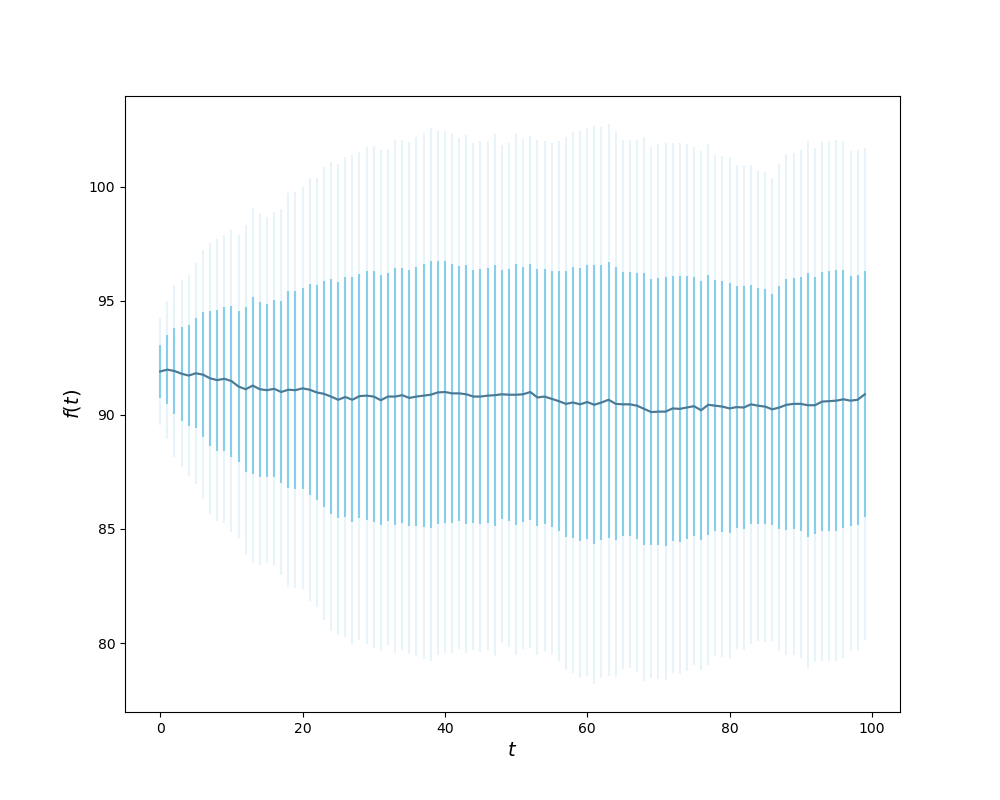

In [172]:
fig, ax = plt.subplots(figsize=[10,8])
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)
#ax.plot(xs, lmbd_sol(xs))

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

In [199]:
def Analytic_Solution(f0,a,b):
    #f0 = 50

    t = symbols('t')
    x = symbols('x', cls=Function)
    L = symbols('L', real=True)
    d = symbols('d', real=True)

    gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

    sol = gsol.subs({L: a,d:b})
    lmbd_sol = lambdify(t, sol.rhs)

    return lmbd_sol

<IPython.core.display.Javascript object>


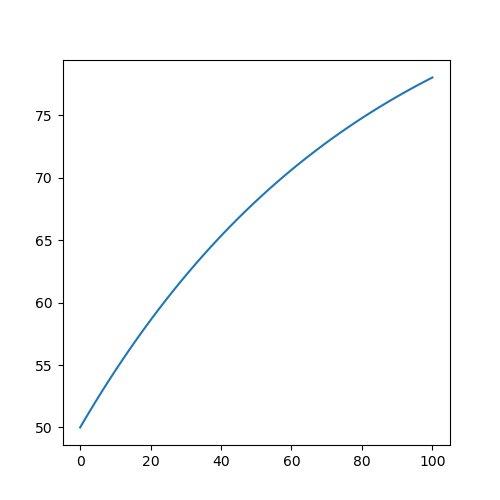

In [185]:
#Analytic_Solution(50)

xs = np.linspace(0,100)

fig, ax = plt.subplots(figsize=[5,5])

plt.plot(xs,Analytic_Solution(50)(xs))

plt.show()

N:  100
L:  180
f:  90
L-f:  90
f+:  45
f-:  45
Delta:  0
Abs(Delta):  0
0.5



completed 3.87656831741333


<IPython.core.display.Javascript object>


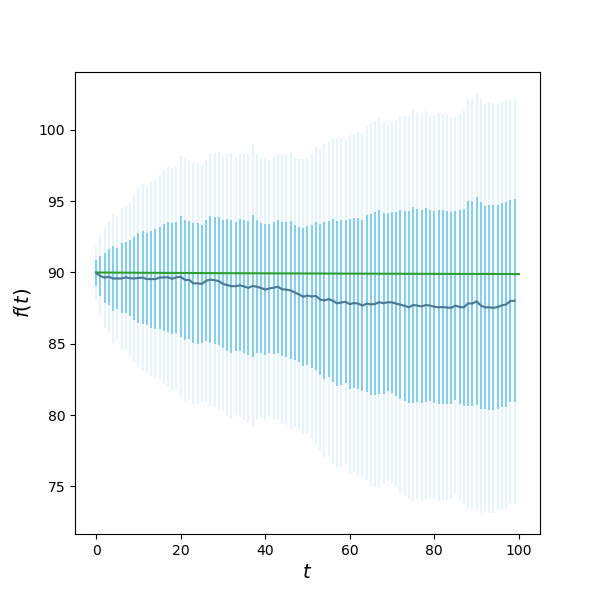

In [196]:
H = simulated_annealing(FG(10,0.5),0)

Properties(H)

results, total = Quench2(H)

fig, ax = plt.subplots(figsize=[6,6])

ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

xs = np.linspace(0,100)
plt.plot(xs,Analytic_Solution(frustration_count2(H))(xs))

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

# Complete Block

In [201]:
def Properties2(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count2(G))
    print("L-f: ",len(G.edges())-frustration_count2(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))

    print(frustration_count2(G)/len(G.edges()))
    
    return len(G.edges()),int(np.sqrt((positive-negative)**2))

In [204]:
def Analytic_Solution2(f0,a,b):
    #f0 = 50

    t = symbols('t')
    x = symbols('x', cls=Function)
    L = symbols('L', real=True)
    d = symbols('d', real=True)

    gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

    sol = gsol.subs({L: a,d:b})
    lmbd_sol = lambdify(t, sol.rhs)

    return lmbd_sol

N:  100
L:  180
f:  82
L-f:  98
f+:  41
f-:  41
Delta:  0
Abs(Delta):  0
0.45555555555555555
180 0



completed 3.898848533630371


<IPython.core.display.Javascript object>


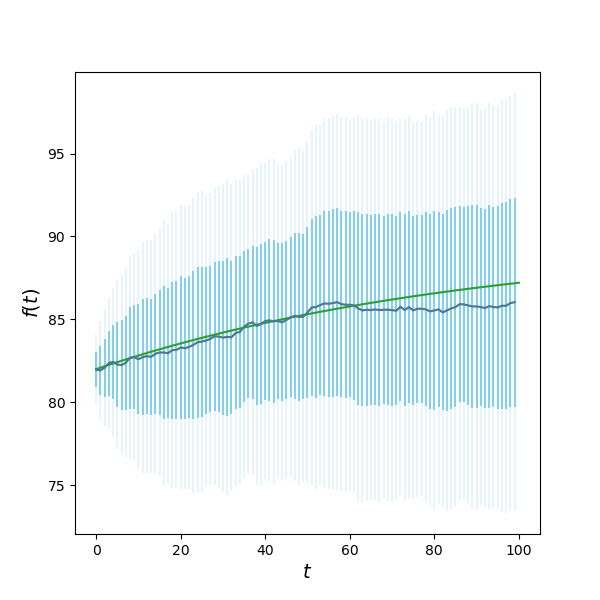

In [207]:
H = simulated_annealing(FG(10,0.5),0)

#G0,var,fi = create_data(10,1)

#H = G0

L,d = Properties2(H)

print(L,d)

results, total = Quench2(H)

fig, ax = plt.subplots(figsize=[6,6])

ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

xs = np.linspace(0,100)
plt.plot(xs,Analytic_Solution2(frustration_count2(H),L,d)(xs))

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

N:  100
L:  180
f:  0
L-f:  180
f+:  0
f-:  0
Delta:  0
Abs(Delta):  0
0.0
180 0



completed 3.9677927494049072


<IPython.core.display.Javascript object>


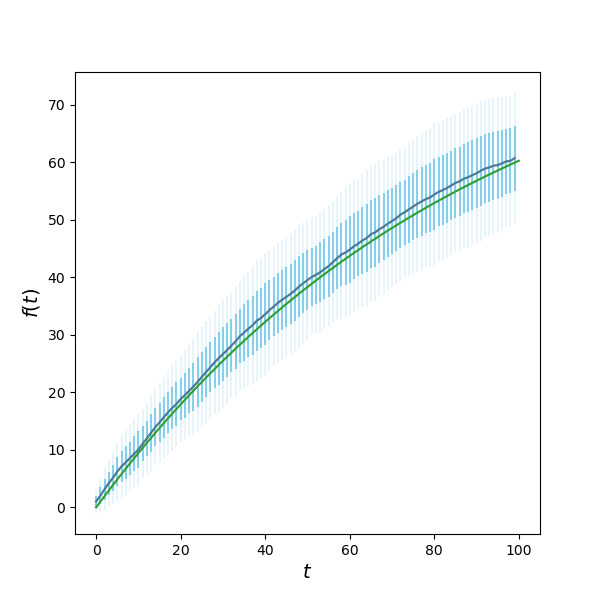

In [208]:
G0,var,fi = create_data(10,2)

H = G0

#H = simulated_annealing(FG(10,0.5),0)

L,d = Properties2(H)

print(L,d)

results, total = Quench2(H)

fig, ax = plt.subplots(figsize=[6,6])

ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

xs = np.linspace(0,100)
plt.plot(xs,Analytic_Solution2(frustration_count2(H),L,d)(xs))

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

N:  66
L:  165
f:  50
L-f:  115
f+:  50
f-:  0
Delta:  50
Abs(Delta):  50
0.30303030303030304
165 50



completed 3.377612590789795


<IPython.core.display.Javascript object>


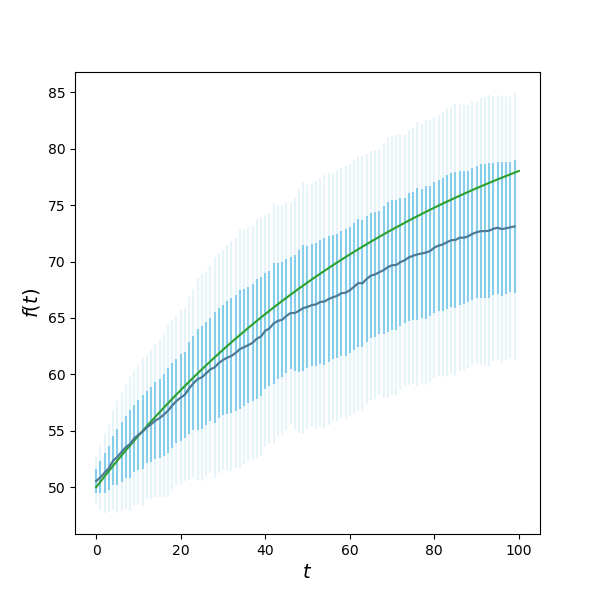

In [209]:
G0,var,fi = create_data(10,1)

H = G0

#H = simulated_annealing(FG(10,0.5),0)

L,d = Properties2(H)

print(L,d)

results, total = Quench2(H)

fig, ax = plt.subplots(figsize=[6,6])

ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

xs = np.linspace(0,100)
plt.plot(xs,Analytic_Solution2(frustration_count2(H),L,d)(xs))

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

N:  10
L:  9
f:  0
L-f:  9
f+:  0
f-:  0
Delta:  0
Abs(Delta):  0
0.0
9 0



completed 0.5926189422607422


<IPython.core.display.Javascript object>


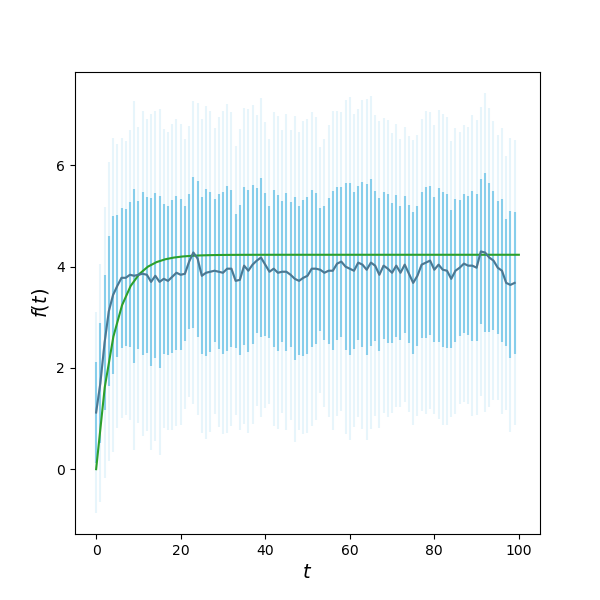

In [210]:
G0,var,fi = create_data(10,3)

H = G0

#H = simulated_annealing(FG(10,0.5),0)

L,d = Properties2(H)

print(L,d)

results, total = Quench2(H)

fig, ax = plt.subplots(figsize=[6,6])

ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

xs = np.linspace(0,100)
plt.plot(xs,Analytic_Solution2(frustration_count2(H),L,d)(xs))

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()